# Analyzing Bridge Traffic in NYC

## Zach Sklar

## Analyzing The Pandemic's Inpact on Traffic

NYC OpenData offers tons of free data. I will be using their data on Automated Traffic Volume Counts. This data is too large to download so I will obtain a subset of data using their API.

Here is a PDF describing the data: https://www1.nyc.gov/html/dot/downloads/pdf/nyc-traffic-counts-report-metadata.pdf. 

Importantly: "Vehicular traffic volumes are collected annually for a two week period either during the fall
months of September, October, and November or during the spring months of March, April,
May, and June. Most of these traffic volumes are collected using Automated Traffic
Recorders (ATRs), which record each vehicle as it passes over a pneumatic tube. A small
percentage are collected using cameras. Average hourly volumes and an average daily
volume are calculated from valid midweek days (Tuesday through Thursday)."

I decided to analyze just the bridges of New York to keep the size of the data managable. I use their API to pass a NoSQL query that pulls data from streets containing the word "BRIDGE." I then store the data into a csv file to save time if I ruin the database in the future.

In [4]:
import pandas as pd
from sodapy import Socrata

client = Socrata("data.cityofnewyork.us", 'KEY', username='USER', password='PASS')

results = client.get("7ym2-wayt", query="SELECT * WHERE street LIKE '%BRIDGE%' LIMIT 27000000")

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df['street'] = df.street.astype(str)
df.to_csv('Traffic_data.csv')

Below I create a dataframe and display the first 5 rows. Despite being just the bridges this is still a lot of data: 16 million rows!

In [31]:
data = pd.read_csv('Traffic_data.csv')
print(data.size)
data.head()

16695315


,Unnamed: 0,requestid,boro,yr,m,d,hh,mm,vol,segmentid,wktgeom,street,fromst,tost,direction
0,0,26734,Manhattan,2017,11,3,22,0,355,137516,POINT (1004175.9505178436 247779.63624949602),WASHINGTON BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB
1,1,31147,Manhattan,2019,10,31,8,0,727,137516,POINT (1004170.6634530823 247782.7882331651),WASHINGTON BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB
2,2,26799,Brooklyn,2017,5,7,14,0,101,22514,POINT (986957.8718474404 185618.57423425745),3 STREET BRIDGE,3 Street,3 Street,EB
3,3,31147,Manhattan,2019,10,25,13,0,234,71036,POINT (1002564.5610851326 240983.75683398134),MACOMBS DAM BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB
4,4,18029,Manhattan,2014,11,14,7,15,496,140775,POINT (996711.0263737534 215086.31906917994),ED KOCH QUEENSBORO BRIDGE,West Main Street,East Main Street,EB


Here are all of the Unique bridges in NYC. When I look at the list, I notice that some of the streets are actually not bridges at all, but streets with the word "Bridge" in them. I suspect they wont do much to taint the data.

In [6]:
print(len(data['street'].unique()))

184


I create a bar chart showing the total volume of cars recorded each year. I do this by grouping the year column and using a sum aggregate on the volume column.

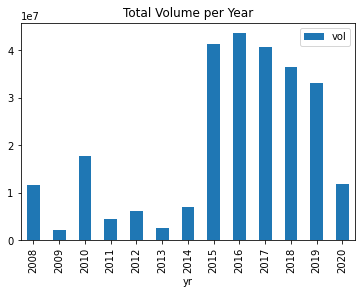

In [33]:
bridge_year = data.groupby(['yr'])['vol'].sum().reset_index()
bridge_year.plot(x='yr', y = 'vol', kind='bar').set_title('Total Volume per Year')
plt.show()


This visualization tells me a lot about the data. Firstly, before 2015, I assume that NYC didn't gather nearly as much traffic data as 2015 and after (I think it is obvious that traffic didn't increase 4 fold in one year). I remove years 2008-2014 from the table and replot to keep the data consistent.

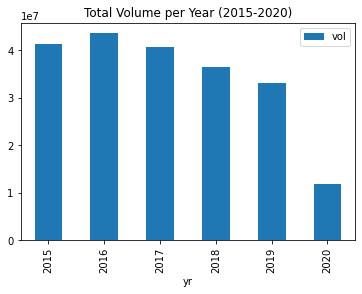

In [37]:
data = data.loc[data['yr'] > 2014]
bridge_year = data.groupby(['yr'])['vol'].sum().reset_index()
bridge_year.plot(x='yr', y = 'vol', kind='bar').set_title('Total Volume per Year (2015-2020)')
plt.show()

Total volume recorded in 2020 looks substantially less in 2020, but this is deceptive. In 2020, due to pandemic actions like lockdowns, far less data was recorded in 2020 than prior years. To get a better read on the data, I will plot each volume point on a scatter plot.

First, though, properly formatting the dates will be useful in the future. I add a date column with datatime objects, and create a time column with the time of day that the data was recorded. I do this by creating a datetime object for the year, month, and day, as well as a string combining hour and minutes.

In [38]:
dates = data[['yr','m','d']]
dates = dates.rename(columns={"yr": "year", "m": "month", "d":"day", "hh":"hour", "mm":"minute"})
dates = pd.to_datetime(dates)
data.insert(2, "date", dates, True)

data['time'] = data['hh'].astype(str).str.pad(width=2, side='left', fillchar='0') + ':' + data['mm'].astype(str).str.pad(width=2, side='left', fillchar='0')

data.head()


,Unnamed: 0,requestid,date,boro,yr,m,d,hh,mm,vol,segmentid,wktgeom,street,fromst,tost,direction,time
0,0,26734,2017-11-03,Manhattan,2017,11,3,22,0,355,137516,POINT (1004175.9505178436 247779.63624949602),WASHINGTON BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB,22:00
1,1,31147,2019-10-31,Manhattan,2019,10,31,8,0,727,137516,POINT (1004170.6634530823 247782.7882331651),WASHINGTON BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB,08:00
2,2,26799,2017-05-07,Brooklyn,2017,5,7,14,0,101,22514,POINT (986957.8718474404 185618.57423425745),3 STREET BRIDGE,3 Street,3 Street,EB,14:00
3,3,31147,2019-10-25,Manhattan,2019,10,25,13,0,234,71036,POINT (1002564.5610851326 240983.75683398134),MACOMBS DAM BRIDGE,Harlem River Shoreline,Harlem River Shoreline,EB,13:00
7,7,21066,2015-09-17,Manhattan,2015,9,17,8,0,26,69318,POINT (1002922.2726578645 233495.61869019107),3 AVENUE BRIDGE,Harlem River Shoreline,Harlem River Shoreline,SB,08:00


Now to make that scatter plot. I use seaborn to create two plots: pandemic and normal. I then overlay the two scatter plots with pandemic in the foreground.

<function matplotlib.pyplot.show(close=None, block=None)>

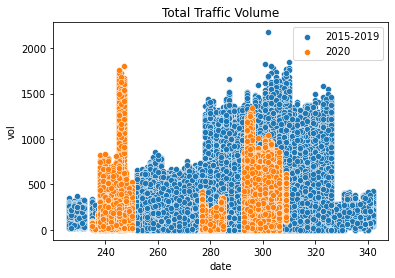

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

pandemic = data.loc[data['yr'] == 2020]

normal = data.loc[data['yr'] < 2020]
normal = normal.loc[normal['m'] > 7]

sns.scatterplot(x=normal['date'].dt.dayofyear, 
            y=normal['vol']).set(title="Total Traffic Volume")
sns.scatterplot(x=pandemic['date'].dt.dayofyear, 
             y=pandemic['vol'])
plt.legend(labels=["2015-2019","2020"])

plt.show

Hmm interesting. What's up with that spike around September? What phase of the pandemic is it when this data was recorded? More needs to be analyzed. Putting the total volume of every bridges into one graph makes this data tough to gather anything useful from. Hopefully, analyzing one bridge at a time will resolve this issue. Below I create a function that will analyze the volume of the bridge that is inputted.

Here is a timeline of Covid in NYC: https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986. Worth noting that traffic data is not recorded at the height of the pandemic. Most of the data recorded was when the city began reopeneing for the first time.  

In [42]:
def pandemic_overlay(name):
    pandemic = data.loc[data['yr'] == 2020]
    pandemic = pandemic.loc[pandemic['street'] == name]

    normal = data.loc[data['yr'] < 2020]
    normal = normal.loc[normal['m'] > 7]
    normal = normal.loc[normal['street'] == name]


    sns.scatterplot(x=normal['date'].dt.dayofyear, 
                    y=normal['vol']).set(title='Volume Recordings: ' + name)
    sns.scatterplot(x=pandemic['date'].dt.dayofyear, 
                    y=pandemic['vol'])
    plt.legend(labels=["2015-2019","2020"])
    

Plotting the Brooklyn bridge is more telling. The volume's recorded are much less on average in 2020.

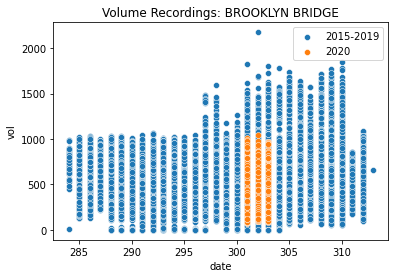

In [43]:
pandemic_overlay("BROOKLYN BRIDGE")

Plotting more bridges. Some tell the same story while others seem to be operating more or less similarly.

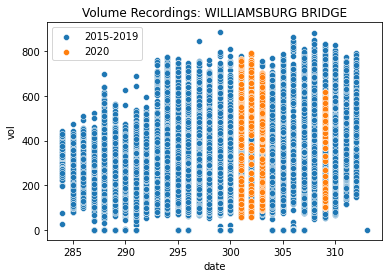

In [44]:
pandemic_overlay('WILLIAMSBURG BRIDGE')

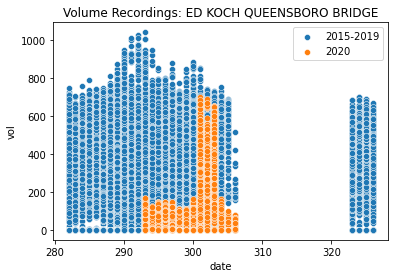

In [45]:
pandemic_overlay('ED KOCH QUEENSBORO BRIDGE')

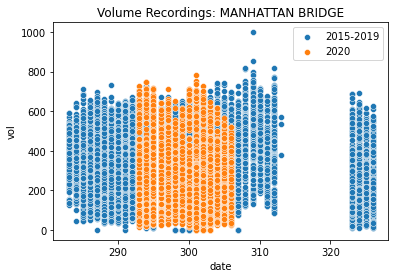

In [46]:
pandemic_overlay('MANHATTAN BRIDGE')

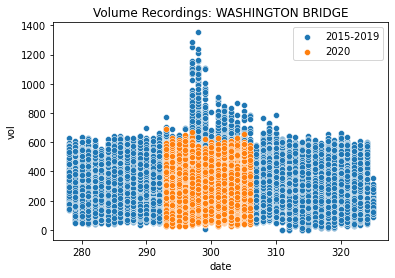

In [47]:
pandemic_overlay('WASHINGTON BRIDGE')

Here I investigate that weird spike in volume from earlier. Looks like in 2020 data was collected at a different than usual schedule for the Kosciuszko Bridge, resulting in the total volume data looking strange.

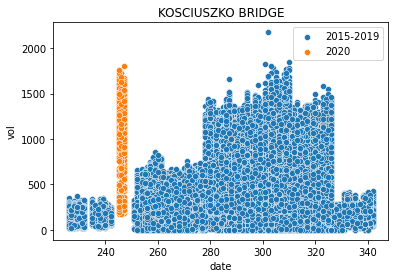

In [48]:
pandemic = data.loc[data['yr'] == 2020]
pandemic = pandemic.loc[(pandemic['street']) == "KOSCIUSZKO BRIDGE"]

normal = data.loc[data['yr'] < 2020]
normal = normal.loc[normal['m'] > 7]


sns.scatterplot(x=normal['date'].dt.dayofyear, 
                        y=normal['vol']).set(title="KOSCIUSZKO BRIDGE")
sns.scatterplot(x=pandemic['date'].dt.dayofyear, 
                        y=pandemic['vol'])
plt.legend(labels=["2015-2019","2020"])

plt.show()

I think a lot can be learned from this data if we compute the average traffic volume per year. Below is a barchart of the average record from all of the bridges per year.

<function matplotlib.pyplot.show(close=None, block=None)>

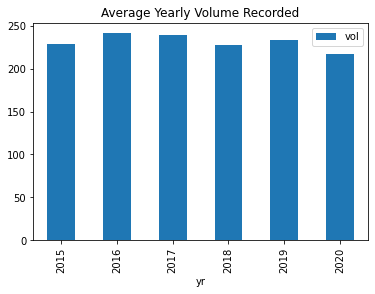

In [51]:
bridge_year = data.groupby(['yr'])['vol'].mean().reset_index()
bridge_year.plot(x='yr', y = 'vol', kind='bar').set_title("Average Yearly Volume Recorded")
plt.show

This looks a little dissapointing; the average yearly recording in 2020 isn't much less than years prior. I plot the average daily volume on a scatter plot to see the data on a more granular level.

<function matplotlib.pyplot.show(close=None, block=None)>

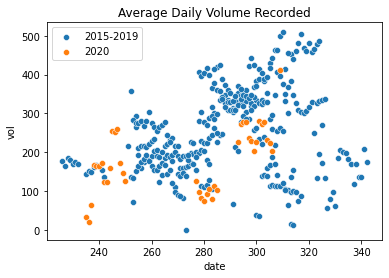

In [52]:
pandemic = data.loc[data['yr'] == 2020]
pandemic = pandemic.groupby(['date','m','d'])['vol'].mean().reset_index()


normal = data.loc[data['yr'] < 2020]
normal = normal.loc[normal['m'] > 7]
normal = normal.groupby(['date','m','d'])['vol'].mean().reset_index()



sns.scatterplot(x=normal['date'].dt.dayofyear, 
                    y=normal['vol']).set(title = "Average Daily Volume Recorded")
sns.scatterplot(x=pandemic['date'].dt.dayofyear, 
                    y=pandemic['vol'])
plt.legend(labels=["2015-2019","2020"])
plt.show

I create a new function similar to pandemic_overlay. This function, however, computes the daily mean volume per bridge instead of the sum.

In [53]:
def pandemic_overlay_mean(name):

    pandemic = data.loc[data['yr'] == 2020]
    pandemic = pandemic.loc[(pandemic['street']) == name]
    pandemic = pandemic.groupby(['date','m','d'])['vol'].mean().reset_index()
    

    normal = data.loc[data['yr'] < 2020]
    normal = normal.loc[normal['m'] > 7]
    normal = normal.loc[normal['street'] == name]
    normal = normal.groupby(['date','m','d'])['vol'].mean().reset_index()


    sns.regplot(x=normal['date'].dt.dayofyear, 
                        y=normal['vol'], ci=None).set(title='Average Daily Volume: ' + name)
    sns.regplot(x=pandemic['date'].dt.dayofyear, 
                        y=pandemic['vol'], ci=None)
    plt.legend(labels=["2015-2019","Reg Line","2020","Reg Line"])


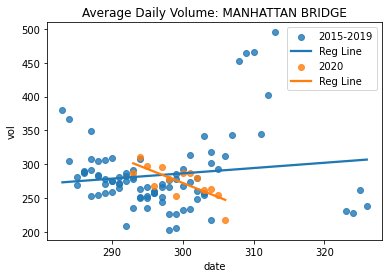

In [54]:
pandemic_overlay_mean("MANHATTAN BRIDGE")

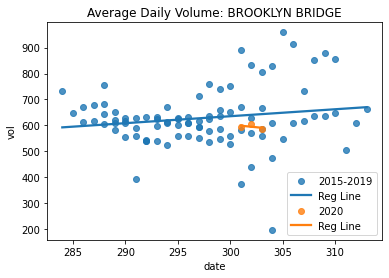

In [55]:
pandemic_overlay_mean("BROOKLYN BRIDGE")

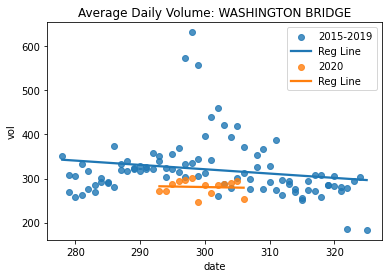

In [56]:
pandemic_overlay_mean("WASHINGTON BRIDGE")

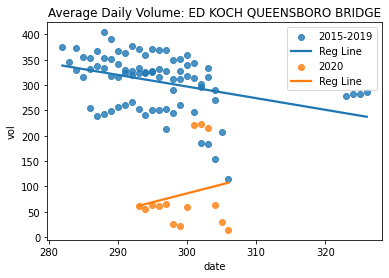

In [57]:
pandemic_overlay_mean("ED KOCH QUEENSBORO BRIDGE")

For specific bridges, it is obvious that less volume is recorded each day.

## Machine Learning: Rush Hour

I'll turn to NYC operating at normal traffic volume by using years 2015-2019 for analysis. 

I want to run a regression model on all of the bridges. Specifically, I'll try to predict traffic volume based on the hour of the day. First, I plot the average volume per hour for all of the bridges.

<function matplotlib.pyplot.show(close=None, block=None)>

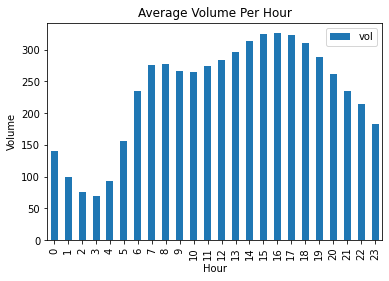

In [58]:
rushhour = data.groupby('hh')['vol'].mean().reset_index()
rushhour.plot(x='hh', y = 'vol', kind='bar').set_title('Average Volume Per Hour')
plt.xlabel("Hour")
plt.ylabel("Volume")

plt.show

Very satisfying! The bar chart above looks exactly how I'd expect it to look. Traffic is the most from 8-9am and 3-7pm.

In order to test the accuracy of the model, I split the data into a training set and a testing set to derive the model's accuracy. Importantly, sampling the data is completely random. 66% of the data will be used for training, and the remaining 34% will be used for testing in the future.

In [26]:
train_data = data.sample(frac = 0.66)
test_data = data.drop(train_data.index)

train_data = data.groupby('time')['vol'].mean().reset_index()
test_data = data.groupby('time')['vol'].mean().reset_index()

I create a polynomial feature with the training data. I chose a degree of 8 after a bit of tweaking as it fits the data neatly. This is all done on the training set. I plot the model on top of the data below.

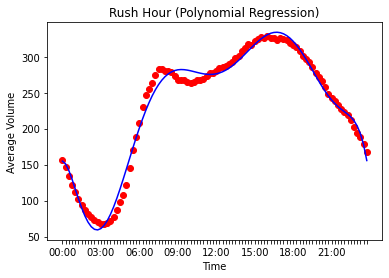

In [66]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np

lb = LabelEncoder()
X = lb.fit_transform(train_data['time']).reshape(-1,1)
y = train_data.vol

poly_reg=PolynomialFeatures(degree= 8)
X_poly=poly_reg.fit_transform(X)
poly_reg.fit(X_poly,y)
lin_reg=LinearRegression()
lin_reg.fit(X_poly,y)

X_grid=np.arange(min(X),max(X),0.1)
X_grid=X_grid.reshape((len(X_grid),1))

fig, ax = plt.subplots()

plt.scatter(X,y,color='red')
plt.plot(lb.inverse_transform(X.ravel()),lin_reg.predict(poly_reg.fit_transform(X)),color='blue')
plt.title('Rush Hour (Polynomial Regression)')
plt.xlabel('Time')
plt.ylabel('Average Volume')
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 12 != 0:
        label.set_visible(False)
plt.show()


The model looks really good; I'm very happy with how it turned out. But is it objectivly good? Now I test the model. I make a prediction using this model with the test data, and subtract the test result to find the margin of error.

In [67]:
X = lb.fit_transform(test_data['time']).reshape(-1,1)

test_data["prediction"] = lin_reg.predict(poly_reg.fit_transform(X))
test_data["accuracy %"] = 100 - abs(((test_data['prediction'] - test_data['vol']) / test_data['vol']) * 100)
test_data.head()

,time,vol,prediction,accuracy %
0,00:00,156.757275,154.902539,98.816810
1,00:15,147.304164,150.951287,97.524087
2,00:30,134.702857,141.888512,94.665551
3,00:45,122.178888,129.763137,93.792505
4,01:00,111.363950,116.232433,95.628313


Finding the average accuracy yields the model's accuracy as a whole.

In [29]:
print('Accuracy: ' + str(test_data['accuracy %'].mean().round(3)) + '%')

Accuracy: 95.488%


Awesome! I can now predict the average traffic volume at any time of day with great accuracy. Here are the best and worst times to take a bridge in New York (unless of course, you like driving slowly).

In [77]:
print('Below is the BEST time to drive')
print(test_data.sort_values('vol').head(1))

print('\nBelow is the WORST time to drive')
print(test_data.sort_values('vol', ascending=False).head(1))


Below is the BEST time to drive
     time        vol  prediction  accuracy %
12  03:00  67.375243   61.140817   90.746712

Below is the WORST time to drive
     time         vol  prediction  accuracy %
64  16:00  328.285453  330.605311   99.293341


This project was a blast to make! Tinkering and playing with data will never get old.